In [11]:
#Downloading the dataset

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

!unzip -q "/content/dogImages"

--2019-12-21 11:45:11--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.88
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  21.3MB/s    in 52s     

2019-12-21 11:46:04 (20.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import cv2

import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms

In [0]:
#Directories

data_dir = "/content/dogImages"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
valid_dir = data_dir + "/valid"





In [0]:
#transforms
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406] ,[0.229, 0.224, 0.225])])
testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406] ,[0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406] ,[0.229, 0.224, 0.225])])

In [0]:
#loading the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validate_set = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_set = datasets.ImageFolder(test_dir, transform=testing_transforms)

#Define dataloaders

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validate_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

In [16]:
#defining model
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:12<00:00, 45.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#freezing pretained parameters to avoid backpropagation during training
for parameter in model.parameters():
  parameter.require_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu',nn.ReLU()),
                                        ('dropout', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 133)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [0]:
 #fuction for validation phase

def validation(model, validate_loader, criterion):

  val_loss = 0
  accuracy = 0

  for images, labels in iter(validate_loader):

    images, labels = images.to('cuda'), labels.to('cuda')

    output = model.forward(images)
    val_loss += criterion(output, labels).item()

    probabilities = torch.exp(output)
    equality = (labels.data == probabilities.max(dim=1)[1])
    accuracy += equality.type(torch.FloatTensor).mean()
  
  return val_loss,accuracy


In [0]:
#loss fuction and gradient descent
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [20]:
#fuction to train the classifier
def train_classifier():

  epochs = 5
  steps = 0
  print_every = 40
  
  model.to('cuda')

  for epoch in range(epochs):
    model.train()

    running_loss = 0

    for images, labels in iter(train_loader):

      steps += 1

      images, labels = images.to('cuda'), labels.to('cuda')

      optimizer.zero_grad()

      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if steps % print_every == 0:

        #set to evaluation mode
        model.eval()

        #turn of gradients, saves memory and computation

        with torch.no_grad():
          validation_loss, accuracy = validation(model, validate_loader, criterion)

          print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                "Validation Accuracy: {:.3f}.. ".format(accuracy/len(validate_loader)))
          
          running_loss = 0
          model.train()

train_classifier()

Epoch: 1/5..  Training Loss: 7.273..  Validation Loss: 2.255..  Validation Accuracy: 0.402.. 
Epoch: 1/5..  Training Loss: 3.111..  Validation Loss: 1.503..  Validation Accuracy: 0.574.. 
Epoch: 2/5..  Training Loss: 0.973..  Validation Loss: 1.308..  Validation Accuracy: 0.640.. 
Epoch: 2/5..  Training Loss: 2.393..  Validation Loss: 1.386..  Validation Accuracy: 0.606.. 
Epoch: 2/5..  Training Loss: 2.370..  Validation Loss: 1.157..  Validation Accuracy: 0.675.. 
Epoch: 3/5..  Training Loss: 1.634..  Validation Loss: 1.091..  Validation Accuracy: 0.688.. 
Epoch: 3/5..  Training Loss: 2.183..  Validation Loss: 1.074..  Validation Accuracy: 0.685.. 
Epoch: 4/5..  Training Loss: 0.251..  Validation Loss: 1.085..  Validation Accuracy: 0.695.. 
Epoch: 4/5..  Training Loss: 2.125..  Validation Loss: 1.079..  Validation Accuracy: 0.686.. 
Epoch: 4/5..  Training Loss: 2.160..  Validation Loss: 1.186..  Validation Accuracy: 0.688.. 
Epoch: 5/5..  Training Loss: 1.050..  Validation Loss: 1.114

In [21]:
def test_accuracy(model, test_loader):

  model.eval()
  model.to('cuda')

  with torch.no_grad():

    accuracy = 0

    for images, labels in iter(test_loader):

      images, labels = images.to('cuda'), labels.to('cuda')
      output = model.forward(images)

      probabilities = torch.exp(output)

      equality = (labels.data == probabilities.max(dim=1)[1])
      accuracy += equality.type(torch.FloatTensor).mean()


    print("Test Accuracy: {}".format(accuracy/len(test_loader)))

test_accuracy(model, test_loader)




Test Accuracy: 0.7337962985038757


In [0]:
#save checkpoint
def save_checkpoint(model):

  model.class_to_idx = training_dataset.class_to_idx

  checkpoint = {'arch': 'vgg16',
                'class_to_idx': model.class_to_idx,
                'model_state_dict': model.state_dict()
                }

  torch.save(checkpoint, 'checkpoint.pth')
save_checkpoint(model)


In [0]:
from PIL import Image
import numpy as np


def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

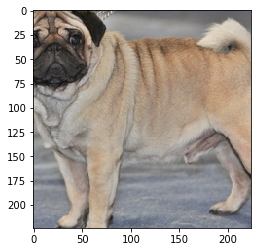

In [24]:
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('/content/pug.jpg')
imshow(image)

In [42]:

# Implement the code to predict the class from an image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('/content/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg', model)   
print(probs)
print(classes)


[0.9344574809074402, 0.06554155051708221, 5.333354735626017e-08, 2.777744978477159e-10, 1.1002167926710271e-10]
['001.Affenpinscher', '038.Brussels_griffon', '042.Cairn_terrier', '117.Pekingese', '100.Lowchen']
